Este notebook realiza un análisis completo: desde el entrenamiento del modelo hasta la clasificación y análisis visual de comentarios reales.

In [1]:
from wordcloud import STOPWORDS, WordCloud

stopwords_es_manual = set("""
a al algo algunas algunos ante antes como con contra cual cuando de del desde donde durante e el ella ellas ellos en entre era eramos eran eres es esa esas ese eso esos esta estaba estaban estado estando estan estar estara estas este esto estos estoy fin fue fueron fui ha
hace hacen hacer hacia hasta he hemos hice hicieron hoy ir la las le les lo los mas me mi mis mucha muchas mucho muchos muy nada ni no nos nosotras nosotros nuestra nuestras nuestro nuestros o os otra otras otro otros para pero poco por porque que quien quienes se sea
segun ser si sido siempre sin sobre soy su sus tambien tanto te tiene tienen toda todas todo todos tu tus tuvo un una unas uno unos usted ustedes va van ver y ya yo solo podria puede pueden puede tener parece hacer tener ser estar estar estaba etc
""".split())

stopwords_finales = stopwords_es_manual.union(STOPWORDS)

stopwords_es_manual.update(['más', 'segun', 'quedó', 'gran', 'varias', 'vender',
    'nadie', 'servicio', 'trato', 'dieron', 'tuvo', 'detalle''instalación', 'parecía', 'según', 'rápido', 'rápidos', 'dudas'])
stopwords_finales = stopwords_es_manual.union(STOPWORDS)


In [2]:
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

### RUTAS - COLUMNAS - LIMPIEZA DE TEXTO

In [4]:
#RUTAS
archivo_entrenamiento = r"C:\Users\57653891\Desktop\tfm\entrenamiento.xlsx"  
archivo_datos_reales = r"C:\Users\57653891\Desktop\tfm\datos_reales_200.xlsx"  
archivo_resultado_reales = r"C:\Users\57653891\Desktop\tfm\comentarios_reales_clasificados.xlsx"  

# COLUMNAS CLAVE 
columna_comentarios = "10. ¿Qué podríamos hacer para mejorar tu experiencia?" 
columna_objetivo = "sentimiento" 

# LIMPIEZA DE TEXTO
def limpiar_texto(texto):  
    texto = str(texto).lower()  
    texto = re.sub(r'[^\w\s]', '', texto)  
    texto = re.sub(r'\d+', '', texto)  
    return texto.strip()  


### ENTRENAMIENTO 

In [5]:
# ENTRENAMIENTO
df_entrenamiento = pd.read_excel(archivo_entrenamiento)  
df_entrenamiento["comentario_limpio"] = df_entrenamiento[columna_comentarios].apply(limpiar_texto)  

vectorizador = TfidfVectorizer(stop_words="english")
X_vect = vectorizador.fit_transform(df_entrenamiento["comentario_limpio"])
y = df_entrenamiento[columna_objetivo]

In [6]:
modelo = LogisticRegression(max_iter=1000)
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, stratify=y, random_state=42)
modelo.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [7]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_vect, y)

joblib.dump(modelo, "modelo_sentimiento.pkl")
joblib.dump(vectorizador, "vectorizador_tfidf.pkl")

['vectorizador_tfidf.pkl']

### VALIDACIÓN DEL MODELO ENTRENADO 

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Predicciones del modelo en test
y_pred = modelo.predict(X_test)

# Reporte de clasificación
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred, target_names=["Negativo", "Neutro", "Positivo"]))

# Mostrar accuracy como porcentaje
accuracy = accuracy_score(y_test, y_pred)
print(f" Exactitud del modelo: {accuracy:.2%}")


=== Reporte de Clasificación ===
              precision    recall  f1-score   support

    Negativo       1.00      1.00      1.00        16
      Neutro       1.00      1.00      1.00        13
    Positivo       1.00      1.00      1.00        14

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

 Exactitud del modelo: 100.00%


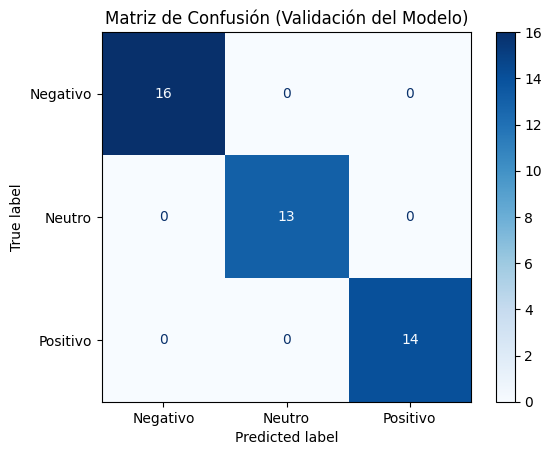

In [9]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo", "Neutro", "Positivo"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión (Validación del Modelo)")
plt.show()
plt.close()

### CLASIFICACIÓN DE DATOS REALES 

In [10]:
df_reales = pd.read_excel(archivo_datos_reales)
df_reales["comentario_limpio"] = df_reales[columna_comentarios].apply(limpiar_texto)

X_reales_vect = vectorizador.transform(df_reales["comentario_limpio"])
df_reales["sentimiento_predicho"] = modelo.predict(X_reales_vect)
df_reales["sentimiento_texto"] = df_reales["sentimiento_predicho"].map({0: "Negativo", 1: "Neutro", 2: "Positivo"})

print(df_reales[["comentario_limpio", "sentimiento_predicho", "sentimiento_texto"]].head())

archivo_resultado_reales = "comentarios_reales_clasificados_con_sentimiento_final.xlsx"
df_reales.to_excel(archivo_resultado_reales, index=False)
print("✅ Archivo guardado con columnas de sentimiento.")

                                   comentario_limpio  sentimiento_predicho  \
0  la atención al cliente no explicó correctament...                     0   
1  el técnico no respondió a mis consultas de for...                     0   
2  el servicio postventa no resolvió el problema ...                     0   
3  el responsable de la instalación reagendó la c...                     0   
4  el técnico no explicó correctamente el funcion...                     0   

  sentimiento_texto  
0          Negativo  
1          Negativo  
2          Negativo  
3          Negativo  
4          Negativo  
✅ Archivo guardado con columnas de sentimiento.


### EXPORTACIÓN 

In [11]:
import pandas as pd
import re
import es_core_news_sm 

nlp = es_core_news_sm.load()
archivo_entrada = "datos_reales_200.xlsx"  # <- archivo de entrada
archivo_resultado_reales = "comentarios_reales_clasificados_con_sentimiento.xlsx"
columna_comentarios = "10. ¿Qué podríamos hacer para mejorar tu experiencia?"

df_reales.to_excel(archivo_resultado_reales, index=False)


def limpiar_texto(texto):
    texto = str(texto).lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\d+', '', texto)
    return texto.strip()

def extraer_sujeto(texto):
    doc = nlp(texto)
    sujetos = [token.text for token in doc if token.dep_ in ("nsubj", "nsubj_pass")]
    return sujetos[0] if sujetos else "No identificado"

df_reales["comentario_limpio"] = df_reales[columna_comentarios].apply(limpiar_texto)
df_reales["sujeto"] = df_reales["comentario_limpio"].apply(extraer_sujeto)

df_reales.to_excel(archivo_resultado_reales, index=False)
print("✅ Archivo generado: comentarios_reales_clasificados.xlsx con columna 'sujeto'")


✅ Archivo generado: comentarios_reales_clasificados.xlsx con columna 'sujeto'


### ANÁLISIS DE PREGUNTAS NUMÉRICAS POR SENTIMIENTO 

In [12]:
# ANÁLISIS DE PREGUNTAS NUMÉRICAS
columnas_numericas = df_reales.columns[:8]  
import pandas as pd
pd.set_option("display.max_columns", None)  

# Mostrar distribución porcentual de sentimientos
porcentajes = df_reales["sentimiento_texto"].value_counts(normalize=True) * 100
porcentajes = porcentajes.round(2).astype(str) + " %"

print("\n Distribución porcentual de sentimientos (datos reales clasificados) ")
for sentimiento, porcentaje in porcentajes.items():
    print(f"{sentimiento}: {porcentaje}")

# Promedios de preguntas numéricas por grupo
df_promedios = df_reales.groupby("sentimiento_texto")[columnas_numericas].mean()  
print("\n Promedios por sentimiento (datos reales clasificados)")  
print(df_promedios)


 Distribución porcentual de sentimientos (datos reales clasificados) 
Negativo: 82.14 %
Positivo: 14.68 %
Neutro: 3.17 %

 Promedios por sentimiento (datos reales clasificados)
                   1. En una escala del 0 al 10, ¿qué probabilidad hay de que recomiendes nuestra empresa a un amigo o familiar?  \
sentimiento_texto                                                                                                                  
Negativo                                                    5.548544                                                               
Neutro                                                      3.875000                                                               
Positivo                                                    6.810811                                                               

                   2. ¿Cómo calificarías el trato con el vendedor?  \
sentimiento_texto                                                    
Negativo             

### Clustering por Sentimiento

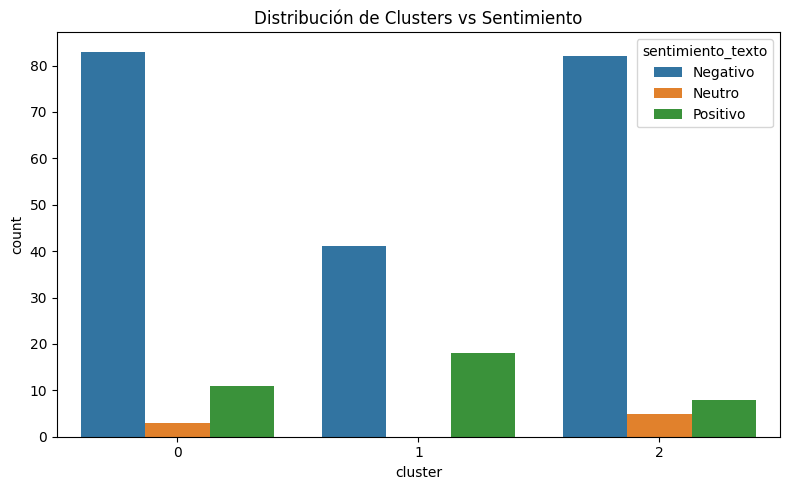

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selección de columnas numéricas (1 a 8) para análisis
columnas_cluster = df_reales.columns[:8]

# Eliminación de filas con valores nulos en esas columnas
df_reales = df_reales.dropna(subset=columnas_cluster)

# Escalado de variables
X_cluster = StandardScaler().fit_transform(df_reales[columnas_cluster])

# Agrupar en 3 clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
df_reales["cluster"] = kmeans.fit_predict(X_cluster)

# Gráfico de distribución de clúster
plt.figure(figsize=(8, 5))
sns.countplot(x="cluster", hue="sentimiento_texto", data=df_reales)
plt.title("Distribución de Clusters vs Sentimiento")
plt.xlabel("cluster")
plt.ylabel("count")
plt.legend(title="sentimiento_texto")
plt.tight_layout()
plt.show()

### HEATMAP 

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\3618094952.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


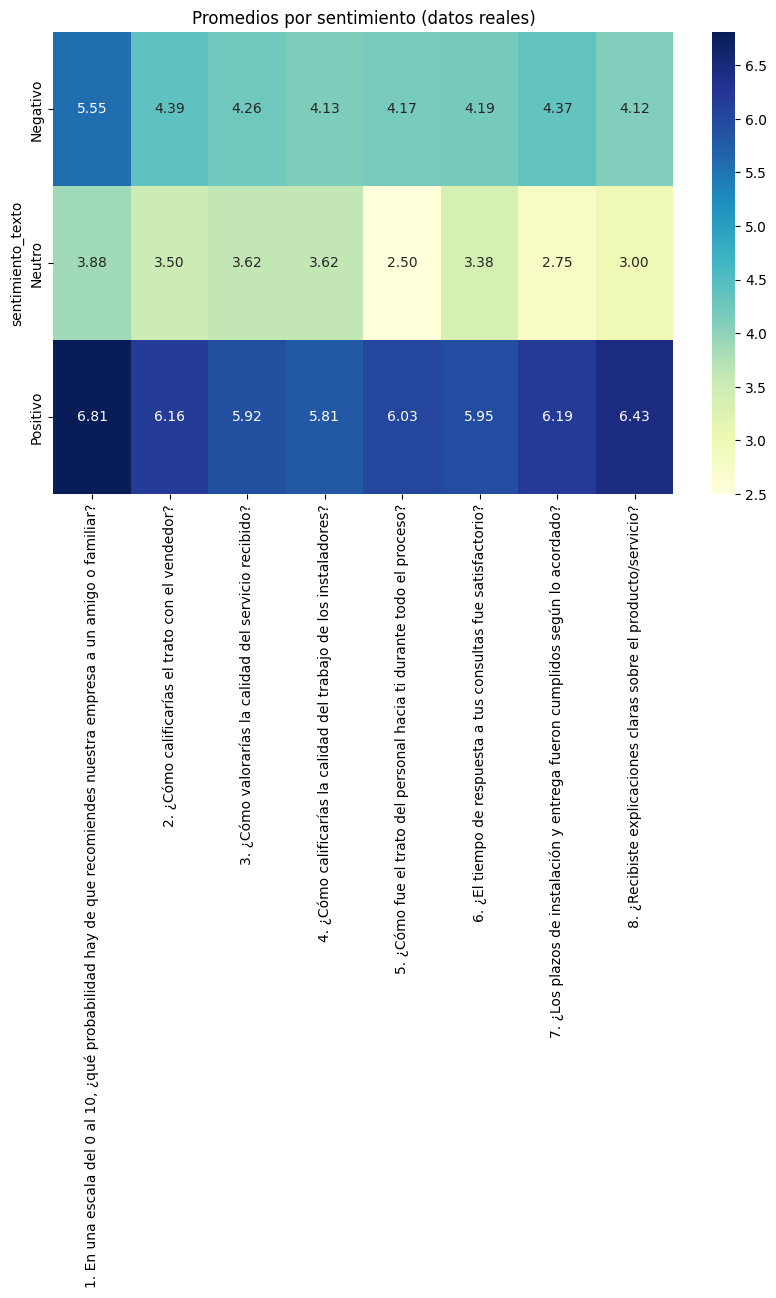

In [14]:
# HEATMAP
plt.figure(figsize=(10, 6))
sns.heatmap(df_promedios, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Promedios por sentimiento (datos reales)")
plt.tight_layout()
plt.show()

### VISUALIZACIÓN DE DATOS REALES CLASIFICADOS

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\40028906.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_reales, x="sentimiento_texto", palette="pastel")


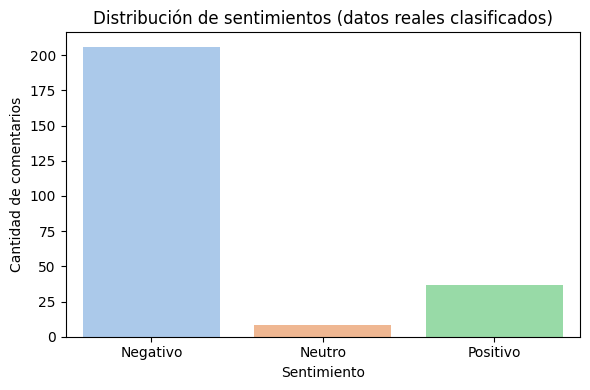

In [15]:
# Conteo por sentimiento
plt.figure(figsize=(6, 4))
sns.countplot(data=df_reales, x="sentimiento_texto", palette="pastel")
plt.title("Distribución de sentimientos (datos reales clasificados)")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de comentarios")
plt.tight_layout()
plt.show()

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\1939859005.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


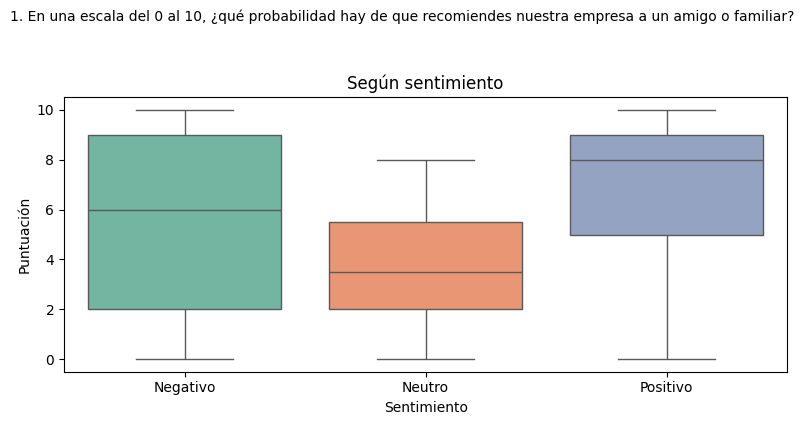

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\1939859005.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


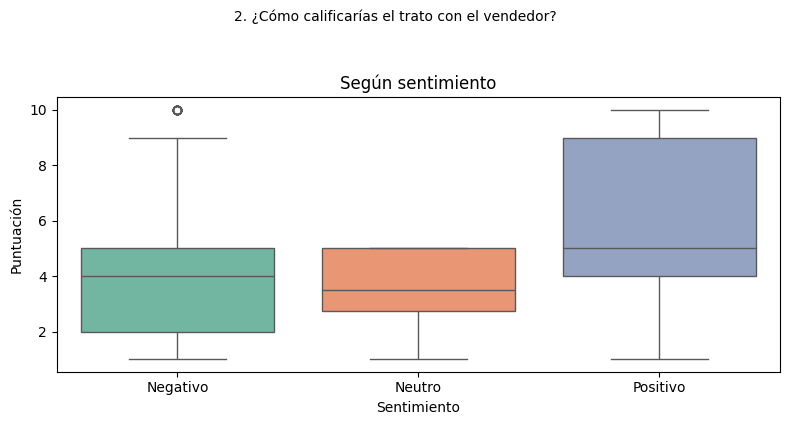

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\1939859005.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


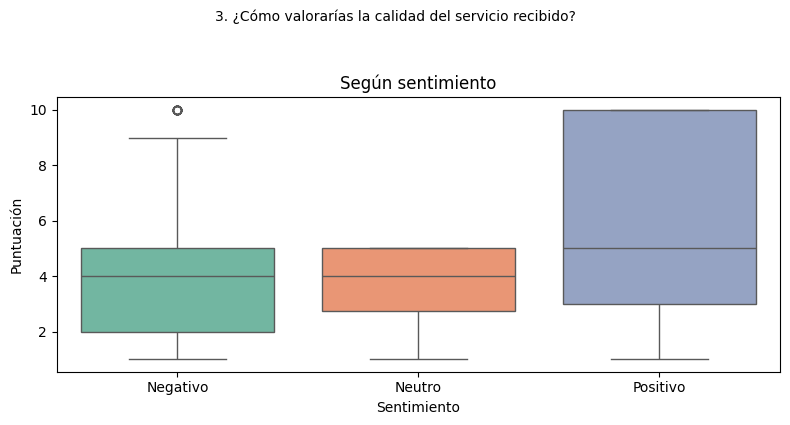

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\1939859005.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


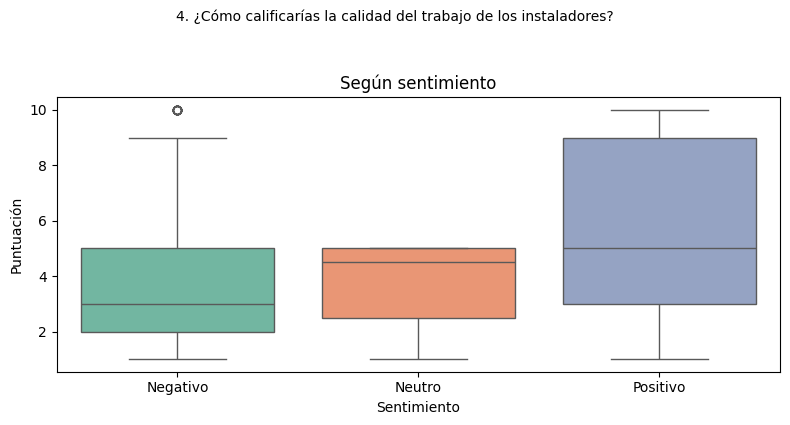

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\1939859005.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


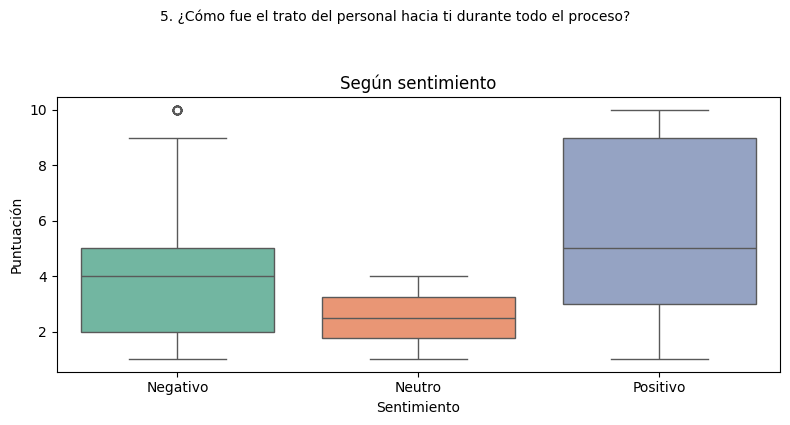

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\1939859005.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


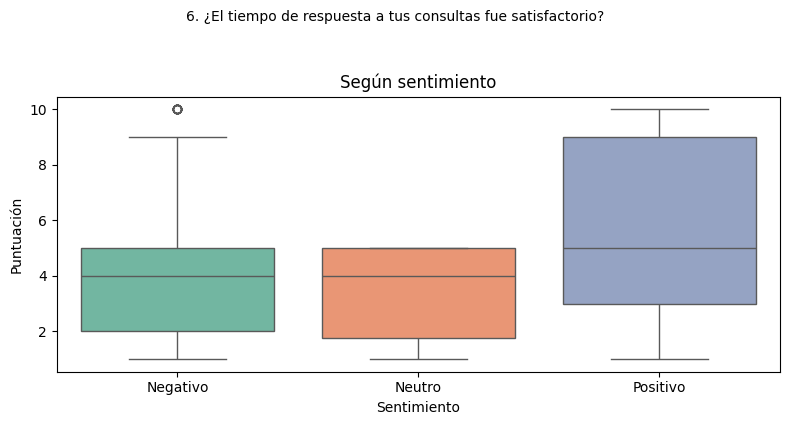

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\1939859005.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


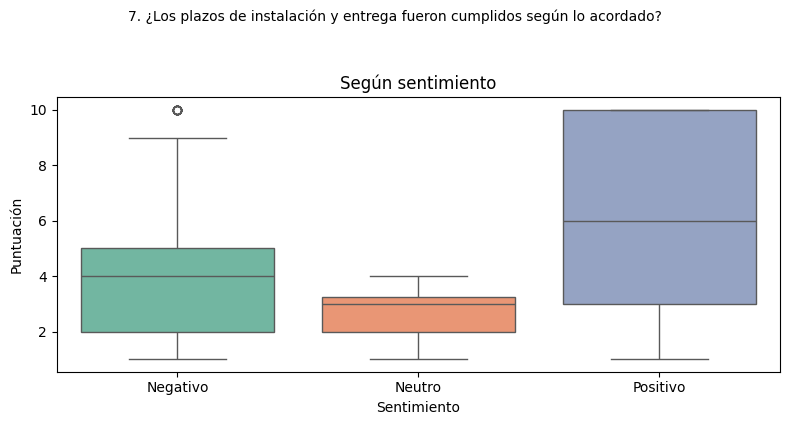

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\1939859005.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


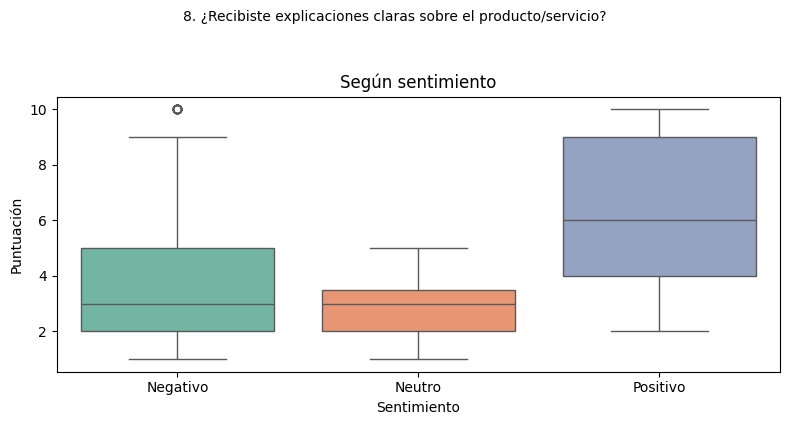

In [16]:
# Boxplots por pregunta 
# mostrar la pregunta arriba del gráfico

for col in columnas_numericas:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")
    plt.title("Según sentimiento")
    plt.suptitle(col, y=1.05, fontsize=10)  
    plt.xlabel("Sentimiento")
    plt.ylabel("Puntuación")
    plt.tight_layout()
    plt.show()


### WORDCLOUD LIMPIOS POR SENTIMIENTO 


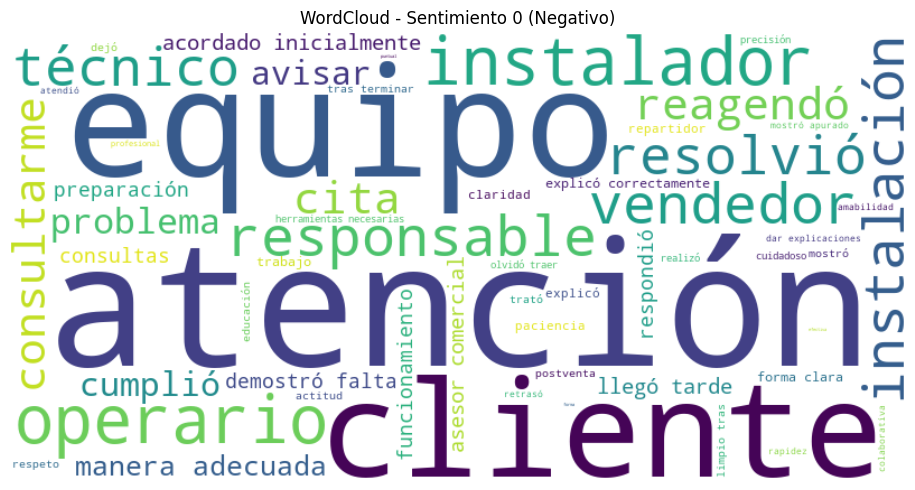

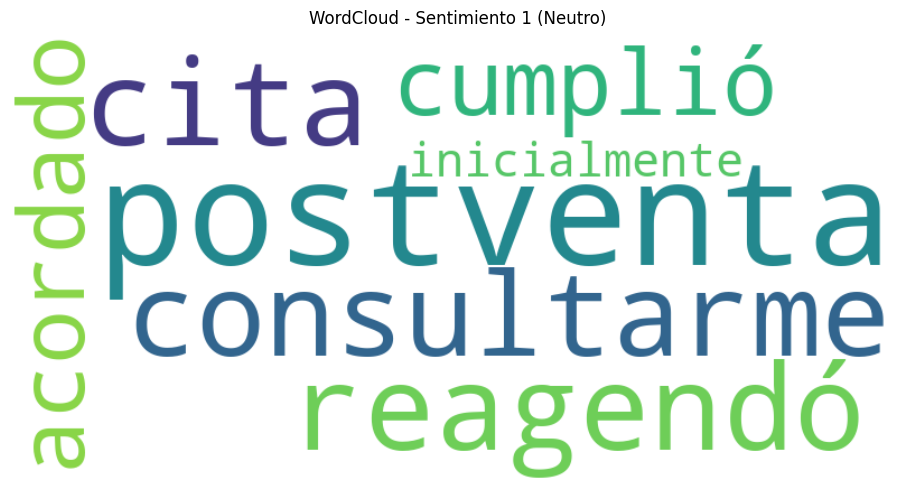

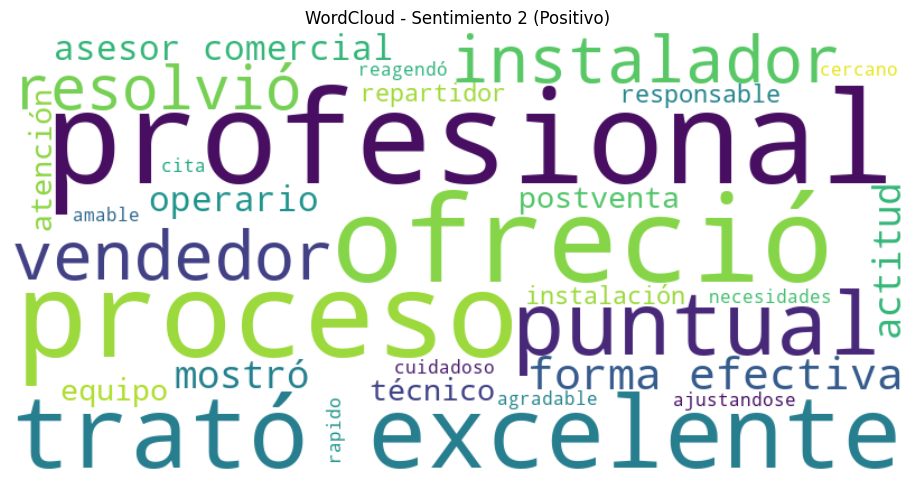

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for clase in sorted(df_reales["sentimiento_predicho"].unique()):
    texto = " ".join(df_reales[df_reales["sentimiento_predicho"] == clase]["comentario_limpio"])
    nube = WordCloud(stopwords=stopwords_finales, width=800, height=400, background_color="white").generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(nube, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - Sentimiento {clase} ({['Negativo', 'Neutro', 'Positivo'][clase]})")
    plt.tight_layout()
    plt.show()
    plt.close()


### BARRAS COMPARATIVAS - TOP PALABRAS NEGATIVO VS POSITIVO 


c:\Users\57653891\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


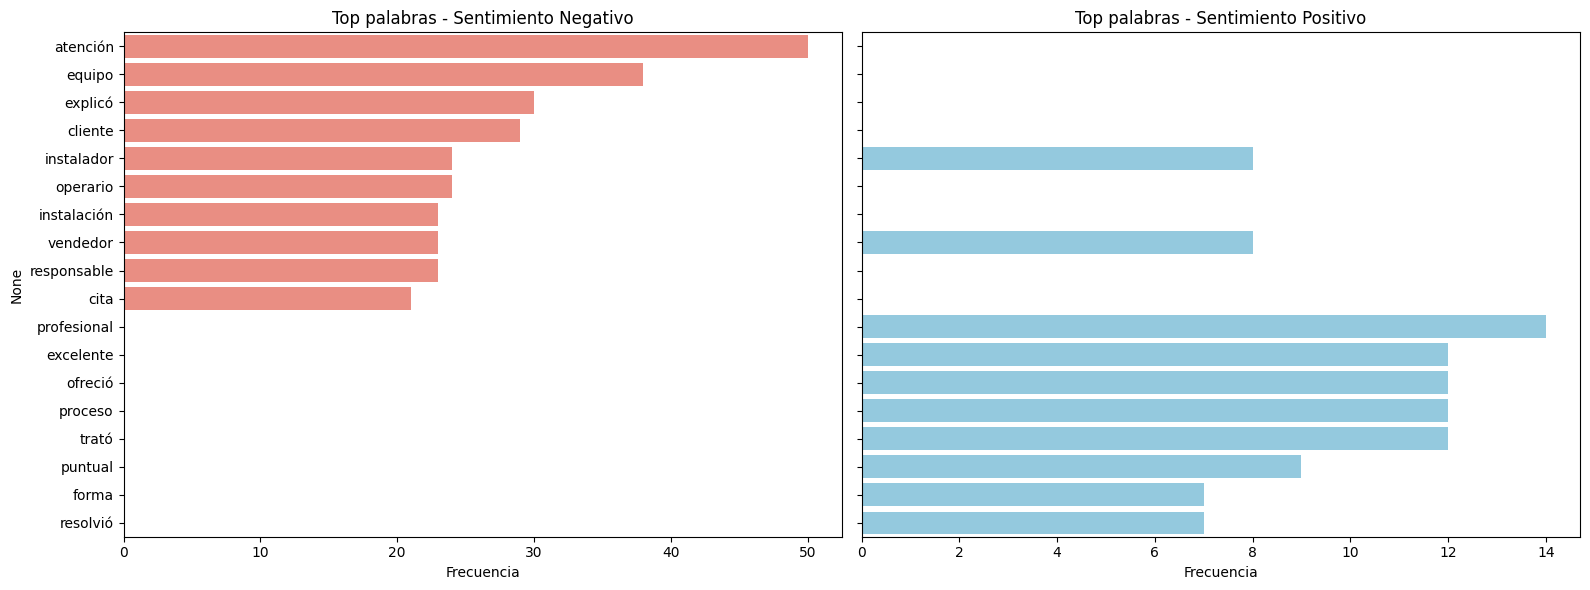

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# ADeben estar los datos de 'comentario_limpio' y 'sentimiento_texto' en df_reales
df_reales = df_reales[df_reales["comentario_limpio"].notnull()]

# Vectorizar
cv = CountVectorizer(stop_words=list(stopwords_finales), min_df=1)
X_counts = cv.fit_transform(df_reales["comentario_limpio"])
df_palabras = pd.DataFrame(X_counts.toarray(), columns=cv.get_feature_names_out())
df_palabras["sentimiento_texto"] = df_reales["sentimiento_texto"].values

# Filtrar por sentimiento
df_neg = df_palabras[df_palabras["sentimiento_texto"] == "Negativo"]
df_pos = df_palabras[df_palabras["sentimiento_texto"] == "Positivo"]

# Verificar que hay datos suficientes
if not df_neg.empty and not df_pos.empty:
    top_neg = df_neg.drop("sentimiento_texto", axis=1).sum().sort_values(ascending=False).head(10)
    top_pos = df_pos.drop("sentimiento_texto", axis=1).sum().sort_values(ascending=False).head(10)

    # Gráfico comparativo
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    sns.barplot(x=top_neg.values, y=top_neg.index, ax=axes[0], color='salmon')
    axes[0].set_title("Top palabras - Sentimiento Negativo")
    axes[0].set_xlabel("Frecuencia")

    sns.barplot(x=top_pos.values, y=top_pos.index, ax=axes[1], color='skyblue')
    axes[1].set_title("Top palabras - Sentimiento Positivo")
    axes[1].set_xlabel("Frecuencia")

    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes comentarios clasificados como Positivo o Negativo para graficar.")

c:\Users\57653891\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


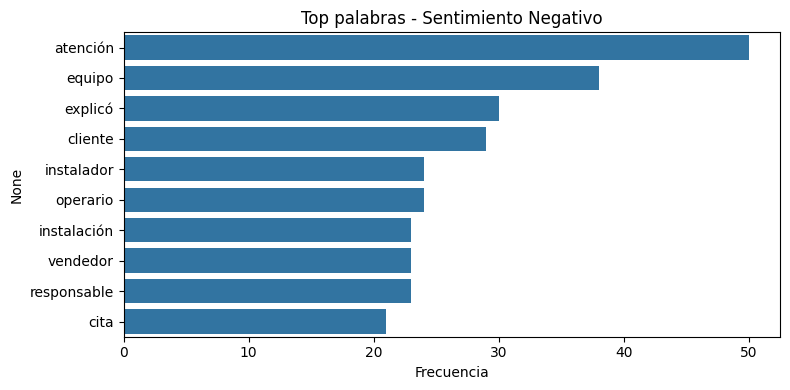

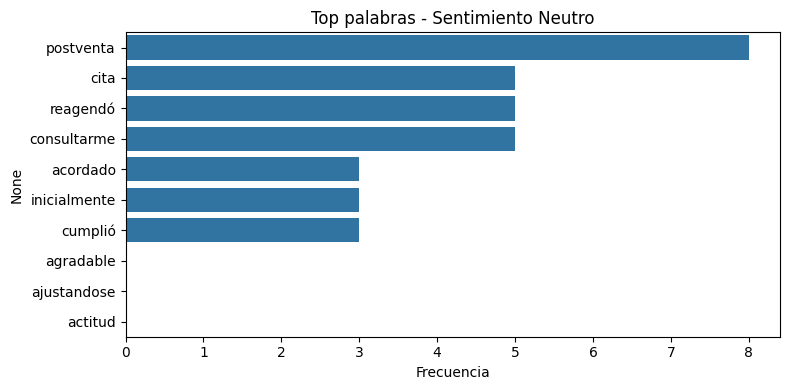

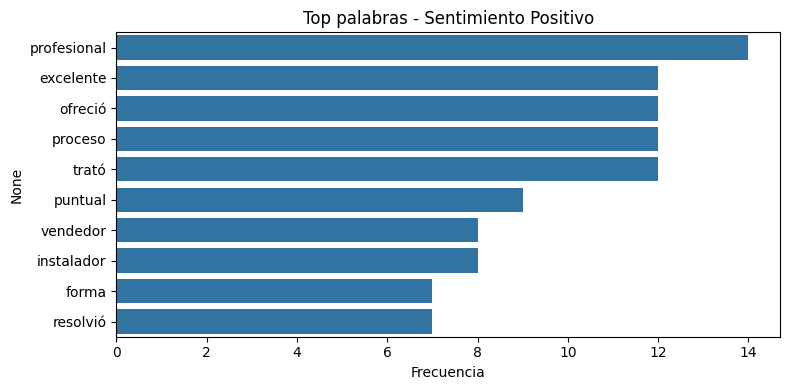

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Diccionario para traducir los códigos de sentimiento a texto
mapa_sentimientos = {0: "Negativo", 1: "Neutro", 2: "Positivo"}

# Vectorizar comentarios ya limpiados
cv = CountVectorizer(stop_words=list(stopwords_finales))
X_counts = cv.fit_transform(df_reales["comentario_limpio"])
df_palabras = pd.DataFrame(X_counts.toarray(), columns=cv.get_feature_names_out())
df_palabras["sentimiento"] = df_reales["sentimiento_predicho"]

# Gráfico por sentimiento con nombre legible
for clase in sorted(df_palabras["sentimiento"].unique()):
    top_palabras = (
        df_palabras[df_palabras["sentimiento"] == clase]
        .drop("sentimiento", axis=1)
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_palabras.values, y=top_palabras.index)
    plt.title(f"Top palabras - Sentimiento {mapa_sentimientos[clase]}")
    plt.xlabel("Frecuencia")
    plt.tight_layout()
    plt.show()



### Relación entre inconvenientes y contenido del comentario

In [22]:
# Crear la columna binaria si no existe
if "inconveniente_binario" not in df_reales.columns: 
    df_reales["inconveniente_binario"] = df_reales["9. ¿Hubo algún inconveniente durante el proceso? (Sí / No)"].map({"Sí": 1, "No": 0})  


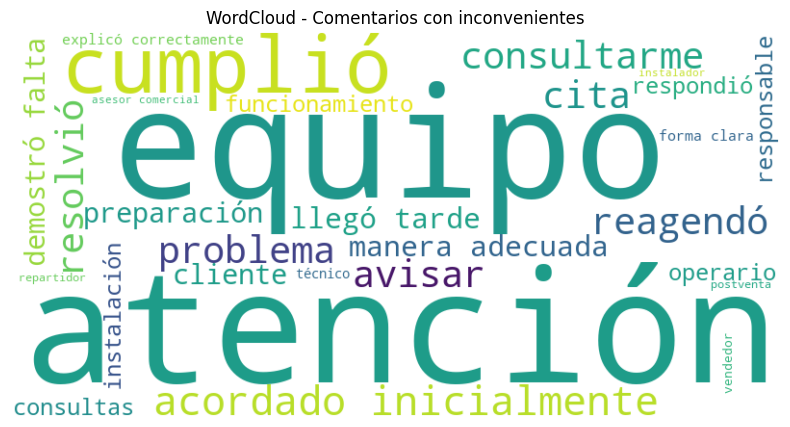

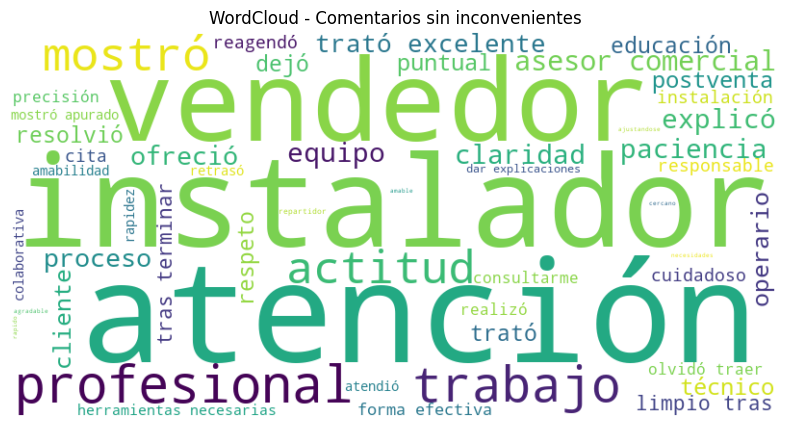

In [23]:
from wordcloud import WordCloud

# WordCloud cuando hubo inconvenientes
comentarios_si = df_reales[df_reales["inconveniente_binario"] == 1]["comentario_limpio"]
texto_si = " ".join(comentarios_si)
nube_si = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords_finales).generate(texto_si)

plt.figure(figsize=(10, 5))
plt.imshow(nube_si, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Comentarios con inconvenientes")
plt.show()

# WordCloud cuando NO hubo inconvenientes
comentarios_no = df_reales[df_reales["inconveniente_binario"] == 0]["comentario_limpio"]
texto_no = " ".join(comentarios_no)
nube_no = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords_finales).generate(texto_no)

plt.figure(figsize=(10, 5))
plt.imshow(nube_no, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Comentarios sin inconvenientes")
plt.show()


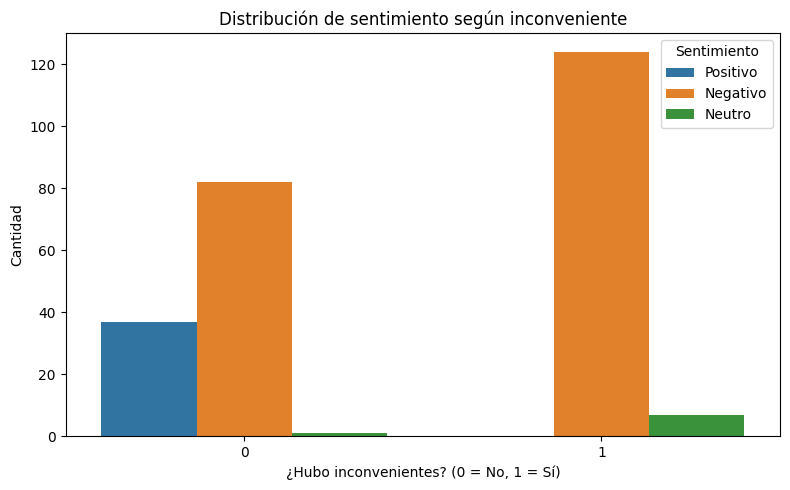

In [24]:
# Conteo de sentimiento por inconveniente
plt.figure(figsize=(8, 5))
sns.countplot(data=df_reales, x="inconveniente_binario", hue="sentimiento_texto")
plt.title("Distribución de sentimiento según inconveniente")
plt.xlabel("¿Hubo inconvenientes? (0 = No, 1 = Sí)")
plt.ylabel("Cantidad")
plt.legend(title="Sentimiento")
plt.tight_layout()
plt.show()


### GRÁFICO: Recomendación vs Sentimiento

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\2220638257.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_plot, x="sentimiento_texto", y=col_recomendacion, jitter=True, alpha=0.6, palette="Set2")


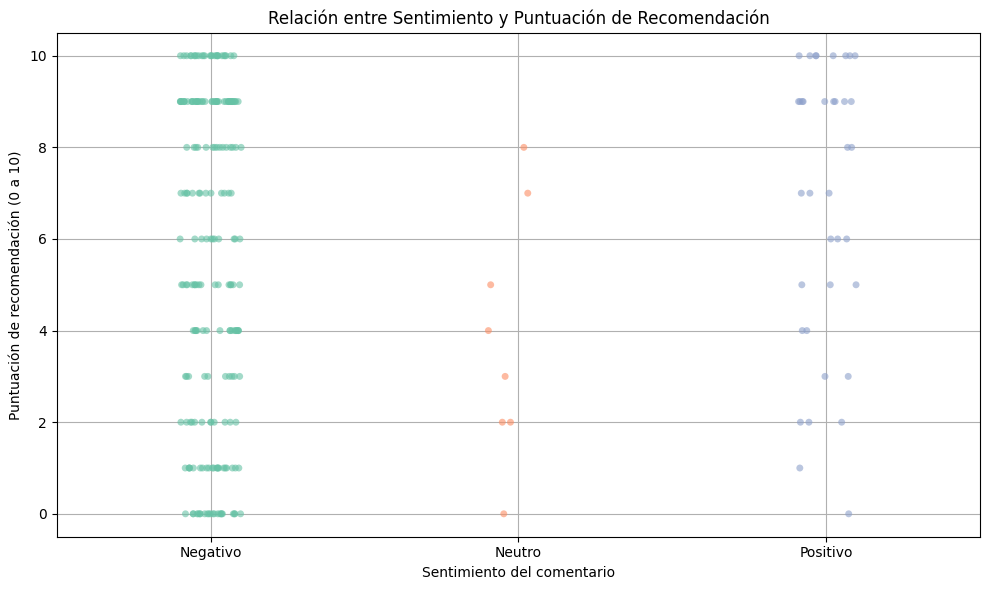

In [25]:
# Nombre de la columna de recomendación
col_recomendacion = "1. En una escala del 0 al 10, ¿qué probabilidad hay de que recomiendes nuestra empresa a un amigo o familiar?"

# Verificamos que existe y convertimos a numérico (por si acaso)
if col_recomendacion in df_reales.columns:
    df_reales[col_recomendacion] = pd.to_numeric(df_reales[col_recomendacion], errors='coerce')
    df_plot = df_reales.dropna(subset=[col_recomendacion, "sentimiento_texto"])

    plt.figure(figsize=(10, 6))
    sns.stripplot(data=df_plot, x="sentimiento_texto", y=col_recomendacion, jitter=True, alpha=0.6, palette="Set2")
    plt.title("Relación entre Sentimiento y Puntuación de Recomendación")
    plt.xlabel("Sentimiento del comentario")
    plt.ylabel("Puntuación de recomendación (0 a 10)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"La columna '{col_recomendacion}' no se encuentra en el DataFrame.")


### Grafico de violín

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\2792074673.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


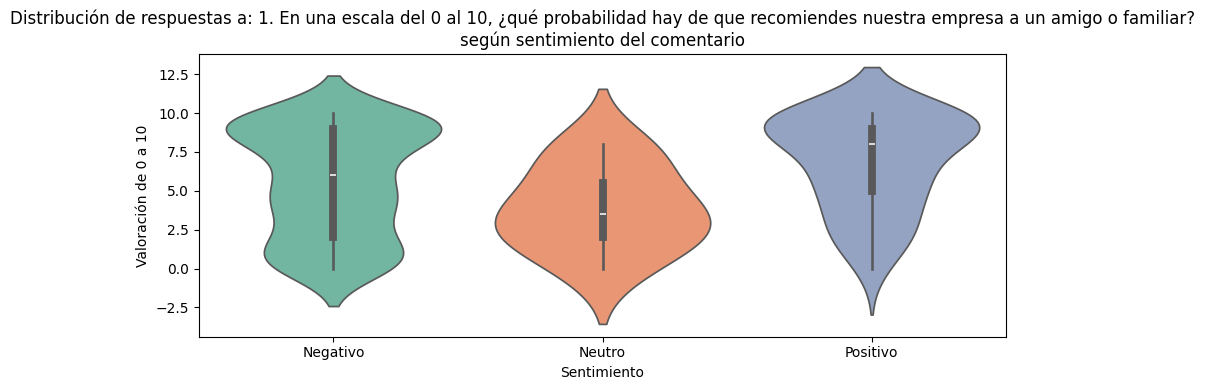

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\2792074673.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


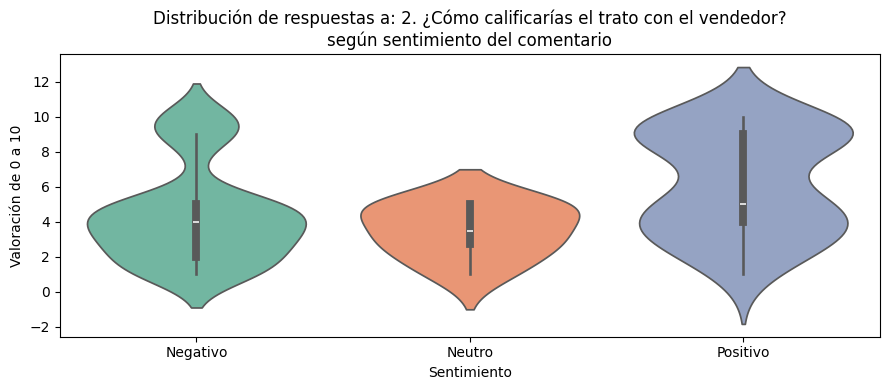

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\2792074673.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


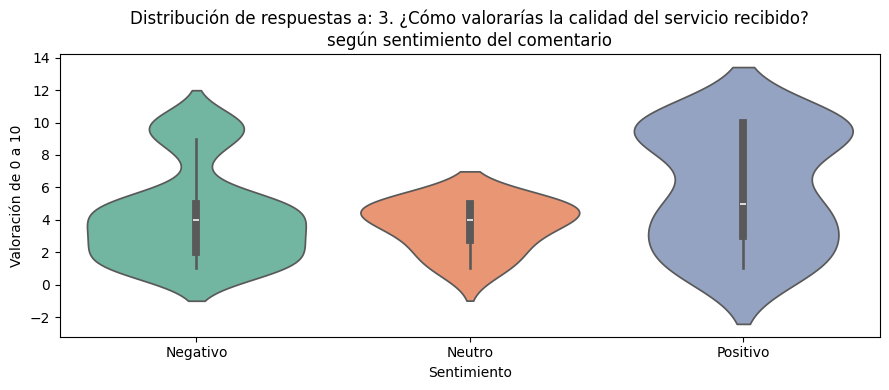

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\2792074673.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


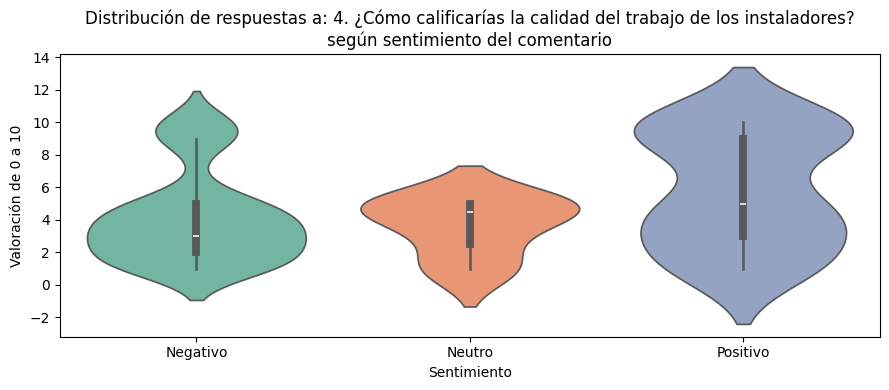

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\2792074673.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


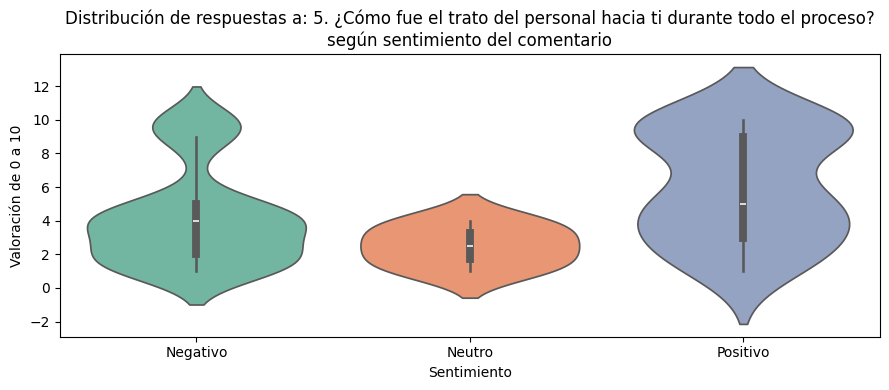

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\2792074673.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


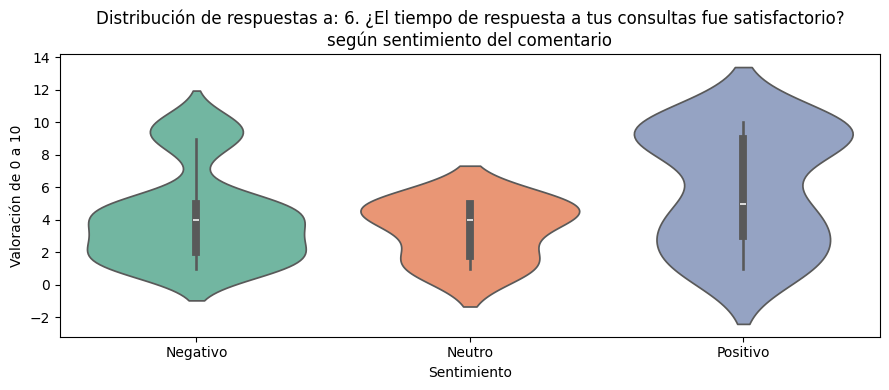

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\2792074673.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


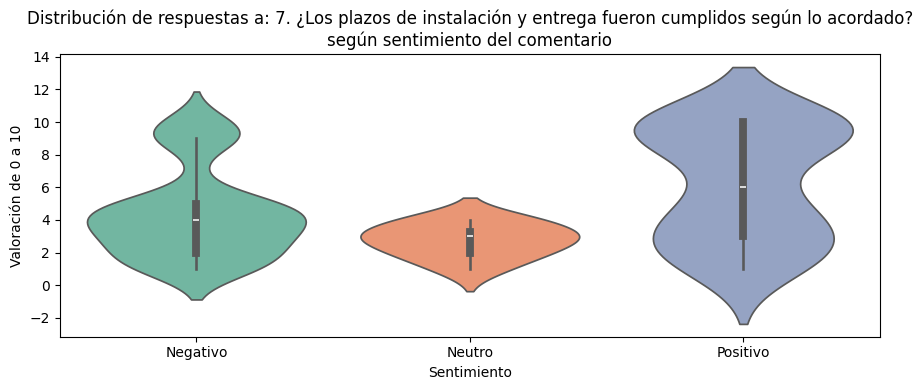

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\2792074673.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")


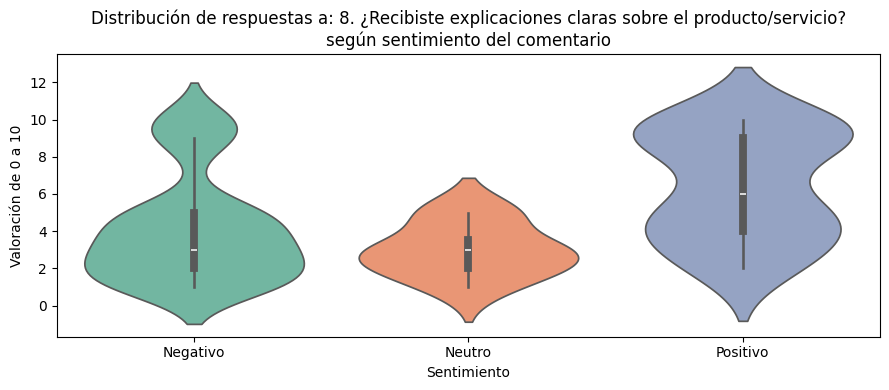

In [26]:
# Gráfico de violín: distribución de valoraciones por pregunta y sentimiento

# Lista de columnas numéricas (preguntas 1 a 8)
columnas_numericas = [
    "1. En una escala del 0 al 10, ¿qué probabilidad hay de que recomiendes nuestra empresa a un amigo o familiar?",
    "2. ¿Cómo calificarías el trato con el vendedor?",
    "3. ¿Cómo valorarías la calidad del servicio recibido?",
    "4. ¿Cómo calificarías la calidad del trabajo de los instaladores?",
    "5. ¿Cómo fue el trato del personal hacia ti durante todo el proceso?",
    "6. ¿El tiempo de respuesta a tus consultas fue satisfactorio?",
    "7. ¿Los plazos de instalación y entrega fueron cumplidos según lo acordado?",
    "8. ¿Recibiste explicaciones claras sobre el producto/servicio?"
]

# Asegurarse de que las columnas son numéricas
for col in columnas_numericas:
    df_reales[col] = pd.to_numeric(df_reales[col], errors="coerce")

# Generar gráfico de violín por cada pregunta
for col in columnas_numericas:
    plt.figure(figsize=(9, 4))
    sns.violinplot(data=df_reales, x="sentimiento_texto", y=col, palette="Set2")
    plt.title(f"Distribución de respuestas a: {col}\nsegún sentimiento del comentario")
    plt.xlabel("Sentimiento")
    plt.ylabel("Valoración de 0 a 10")
    plt.tight_layout()
    plt.show()


### Heatmap de correlación entre preguntas y sentimiento
Este heatmap muestra qué preguntas (de la 1 a la 8) tienen una correlación más fuerte con el sentimiento general expresado en el comentario.

Si una pregunta tiene un valor cercano a +1, significa que una mayor puntuación se asocia a un comentario positivo.

Si está cerca de 0, esa pregunta no influye demasiado en el tono emocional del comentario.

Si estuviera en negativo (poco común), indicaría una inversión emocional: por ejemplo, puntuaciones altas pero que generan comentarios negativos.

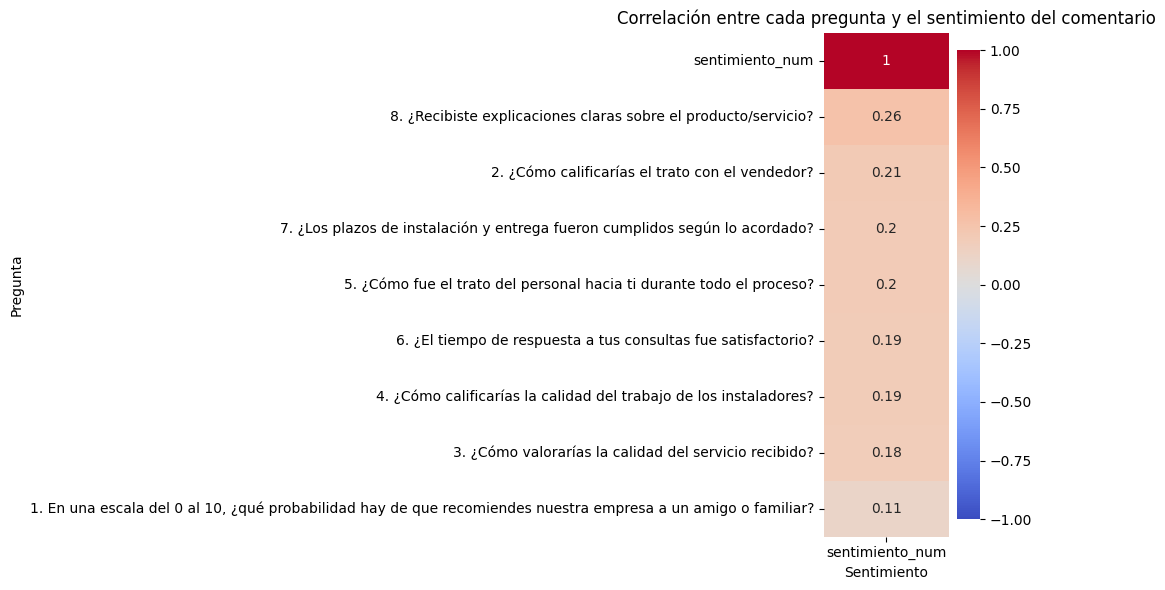

In [27]:
# Convertir sentimiento a número para análisis de correlación
df_reales["sentimiento_num"] = df_reales["sentimiento_predicho"]

# Seleccionar las columnas numéricas
columnas_numericas = [
    "1. En una escala del 0 al 10, ¿qué probabilidad hay de que recomiendes nuestra empresa a un amigo o familiar?",
    "2. ¿Cómo calificarías el trato con el vendedor?",
    "3. ¿Cómo valorarías la calidad del servicio recibido?",
    "4. ¿Cómo calificarías la calidad del trabajo de los instaladores?",
    "5. ¿Cómo fue el trato del personal hacia ti durante todo el proceso?",
    "6. ¿El tiempo de respuesta a tus consultas fue satisfactorio?",
    "7. ¿Los plazos de instalación y entrega fueron cumplidos según lo acordado?",
    "8. ¿Recibiste explicaciones claras sobre el producto/servicio?",
    "sentimiento_num"
]

# Asegurarse que todos sean numéricos
df_cor = df_reales[columnas_numericas].apply(pd.to_numeric, errors="coerce")

# Calcular la correlación
matriz_corr = df_cor.corr().round(2)

# Mostrar heatmap de correlación con el sentimiento
plt.figure(figsize=(10, 6))
sns.heatmap(matriz_corr[["sentimiento_num"]].sort_values("sentimiento_num", ascending=False), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlación entre cada pregunta y el sentimiento del comentario")
plt.xlabel("Sentimiento")
plt.ylabel("Pregunta")
plt.tight_layout()
plt.show()


### Comparativa entre clientes con y sin inconvenientes

Permite ver si los clientes que indicaron haber tenido inconvenientes escribieron comentarios más negativos.

También permite detectar si hay clientes sin inconvenientes que igualmente dejaron comentarios neutros o negativos, lo cual puede reflejar falta de empatía, claridad o proactividad.

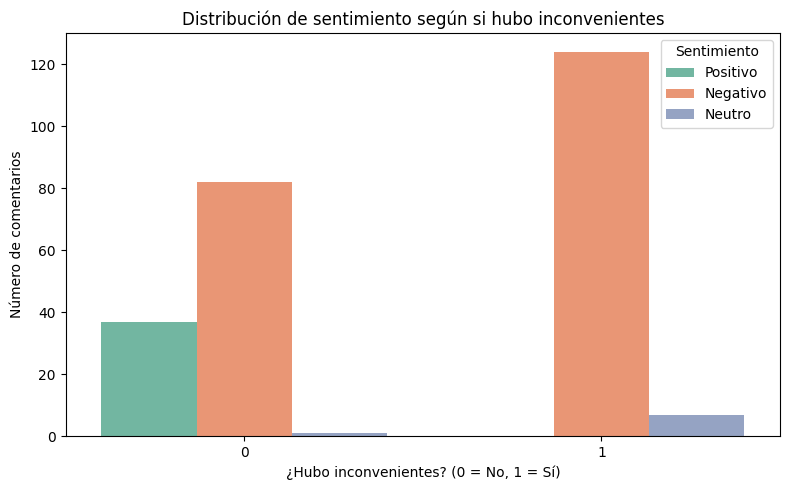

In [28]:
# Asegurarse de que exista la columna binaria
if "inconveniente_binario" not in df_reales.columns:
    df_reales["inconveniente_binario"] = df_reales["9. ¿Hubo algún inconveniente durante el proceso? (Sí / No)"].map({"Sí": 1, "No": 0})

# Gráfico de distribución
plt.figure(figsize=(8, 5))
sns.countplot(data=df_reales, x="inconveniente_binario", hue="sentimiento_texto", palette="Set2")
plt.title("Distribución de sentimiento según si hubo inconvenientes")
plt.xlabel("¿Hubo inconvenientes? (0 = No, 1 = Sí)")
plt.ylabel("Número de comentarios")
plt.legend(title="Sentimiento")
plt.tight_layout()
plt.show()



### Frecuencia de temas de mejora vs Puntuación de Recomendación

Detecta qué palabras clave aparecen frecuentemente en comentarios negativos y cómo afectan la puntuación de recomendación.

Permite identificar temas recurrentes que bajan directamente la nota general.

C:\Users\57653891\AppData\Local\Temp\ipykernel_17800\793530695.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_impacto, x="media_recomendacion", y="palabra", palette="Reds_r")


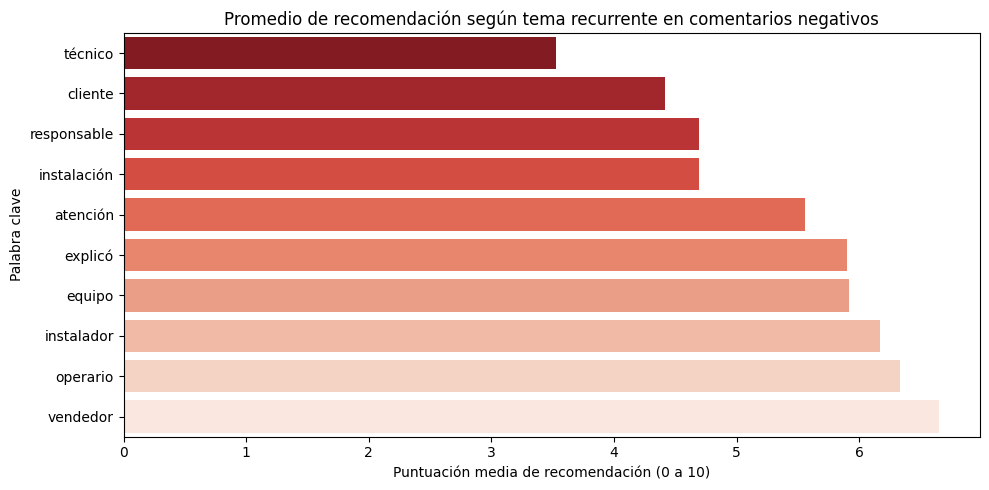

In [29]:
from collections import Counter

# Filtrar comentarios negativos
comentarios_negativos = df_reales[df_reales["sentimiento_texto"] == "Negativo"]

# Tokenización y filtrado
palabras = []
for texto in comentarios_negativos["comentario_limpio"]:
    tokens = texto.split()
    palabras.extend([
        t for t in tokens
        if t not in stopwords_finales and len(t) > 3 and t not in [
            'solo', 'también', 'puede', 'dieron', 'fueron', 'tener', 'tenerlo', 'hacer', 'hicieron', 'dejaron'
        ]
    ])

# Obtener las 10 palabras más frecuentes
conteo = Counter(palabras).most_common(10)
palabras_frecuentes = [palabra for palabra, _ in conteo]

# Calcular el promedio de recomendación por palabra
recomendacion_col = "1. En una escala del 0 al 10, ¿qué probabilidad hay de que recomiendes nuestra empresa a un amigo o familiar?"
impacto = []

for palabra in palabras_frecuentes:
    subconjunto = comentarios_negativos[comentarios_negativos["comentario_limpio"].str.contains(rf"\b{palabra}\b", regex=True)]
    promedio = subconjunto[recomendacion_col].mean()
    impacto.append((palabra, promedio))

# DataFrame y gráfico
df_impacto = pd.DataFrame(impacto, columns=["palabra", "media_recomendacion"]).sort_values(by="media_recomendacion")

plt.figure(figsize=(10, 5))
sns.barplot(data=df_impacto, x="media_recomendacion", y="palabra", palette="Reds_r")
plt.title("Promedio de recomendación según tema recurrente en comentarios negativos")
plt.xlabel("Puntuación media de recomendación (0 a 10)")
plt.ylabel("Palabra clave")
plt.tight_layout()
plt.show()

